Comparisons shown in this notebook:
1) EWT vs SWT vs DWT vs AFD vs HWT vs SSA vs VMD vs EMD
3) Perform Deep Learning analysis using MealPy
4) Use a new classifier
5) Check if model poisoning & inference poisoning attacks can be done on ML models

1) Working on identifying a novel/optimized approach for denoising of ECG signal. 
    1) should be computationally inexpensive
    2) must preserve morphological features
    3) should be applicable in real-time

In [56]:
import pandas as pd
import numpy as np
import os
import wfdb
from pathlib import Path
import pywt
from scipy.linalg import hankel
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from vmdpy import VMD
from scipy.signal import hilbert
from scipy.signal import find_peaks
import time

In [26]:
def dwt_denoise(ecg_signal, wavelet='db6', level=9):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    denoised_signal = pywt.waverec(coeffs_thresh, wavelet)
    return denoised_signal

In [27]:
def hwt_denoise(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, 'haar', level=4)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    denoised_signal = pywt.waverec(coeffs_thresh, 'haar')
    return denoised_signal

In [41]:
def swt_denoise(ecg_signal, wavelet='db6', level=5):
    max_level = pywt.swt_max_level(len(ecg_signal))
    coeffs = pywt.swt(ecg_signal, wavelet, level=max_level)  
    denoised_coeffs = [(pywt.threshold(cA, np.std(cA), mode='soft'), cD) for cA, cD in coeffs]
    denoised_signal = pywt.iswt(denoised_coeffs, wavelet)
    return denoised_signal

In [45]:
def emd_denoise(signal, max_imfs=5, max_iter=100):
    """
    Empirical Mode Decomposition (EMD) without EMDpy
    :param signal: Input ECG signal
    :param max_imfs: Maximum number of Intrinsic Mode Functions (IMFs)
    :param max_iter: Maximum sifting iterations
    :return: Denoised signal
    """
    imfs = []
    residual = signal.copy()  # Ensure we don't modify original signal

    for _ in range(max_imfs):
        h = residual.copy()
        for _ in range(max_iter):
            max_peaks, _ = find_peaks(h)
            min_peaks, _ = find_peaks(-h)

            if len(max_peaks) < 2 or len(min_peaks) < 2:
                break  # Stop if no more decomposition possible

            # Compute upper and lower envelopes
            upper_envelope = np.interp(np.arange(len(h)), max_peaks, h[max_peaks])
            lower_envelope = np.interp(np.arange(len(h)), min_peaks, h[min_peaks])
            
            mean_envelope = (upper_envelope + lower_envelope) / 2
            h = h - mean_envelope  # Subtract mean envelope

        imfs.append(h)
        residual = residual - h  # Remove extracted IMF

        if np.all(np.abs(residual) < 1e-6):  
            break  # Stop if residual is small

    # Remove first IMF (high-frequency noise) and reconstruct signal
    imfs[0] = np.zeros_like(imfs[0])  
    denoised_signal = np.sum(imfs, axis=0)  

    return denoised_signal

In [30]:
def vmd_denoise(ecg_signal, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-6):
    u, _, _ = VMD(ecg_signal, alpha, tau, K, DC, init, tol)
    denoised_signal = np.sum(u, axis=0)
    return denoised_signal

In [57]:
def ssa_denoise(ecg_signal, window_size=50):
    N = len(ecg_signal)

    # Ensure window size is not too large
    window_size = min(window_size, N // 2)

    # Construct trajectory matrix
    trajectory_matrix = np.array([ecg_signal[i:N - window_size + i + 1] for i in range(window_size)])

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(trajectory_matrix, full_matrices=False)

    # Determine rank adaptively
    rank = max(2, int(0.1 * window_size))
    rank = min(rank, len(S))  # Avoid out-of-bounds error

    # Low-rank approximation
    denoised_trajectory = np.dot(U[:, :rank], np.dot(np.diag(S[:rank]), V[:rank, :]))

    # Diagonal averaging to reconstruct signal
    denoised_signal = np.zeros(N)
    counts = np.zeros(N)

    for i in range(window_size):
        denoised_signal[i:N - window_size + i + 1] += denoised_trajectory[i]
        counts[i:N - window_size + i + 1] += 1

    denoised_signal /= counts  # Normalize by the number of overlapping elements

    return denoised_signal


In [50]:
def afd_denoise(ecg_signal, num_modes=10):
    from scipy.fftpack import fft, ifft
    
    # Apply FFT
    freq_domain = fft(ecg_signal)
    
    # Adaptive filtering: Use a threshold instead of a hard cutoff
    threshold = np.percentile(np.abs(freq_domain), 100 - num_modes)
    freq_domain[np.abs(freq_domain) < threshold] = 0  # Keep dominant modes
    
    # Inverse FFT to get denoised signal
    denoised_signal = np.real(ifft(freq_domain))

    return denoised_signal

In [33]:
def ewt_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

In [34]:
def snratio(original_signal, processed_signal):
    noise = original_signal - processed_signal
    return 10 * np.log10(np.sum(original_signal**2) / np.sum(noise**2))

In [35]:
def mserror(original_signal, processed_signal):
    return np.mean((original_signal - processed_signal)**2)

In [36]:
def energy_retention(original_signal, processed_signal):
    return np.sum(processed_signal**2) / np.sum(original_signal**2) * 100

In [37]:
file_path = Path('C:/Users/vinay/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0')
file_name = '100'
file = os.path.join(file_path, file_name)

In [60]:
signal, field = wfdb.rdsamp(file)
ecg_signal = signal[:10000, 0]

In [63]:
def buttworth(ecg_signal, fs=360, lowcut=0.5, highcut=45):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    return(filtfilt(b, a, ecg_signal))

In [72]:
start = time.time()
filtered_signal = buttworth(ecg_signal)
end = time.time()
print((end-start)*1000)

0.9987354278564453


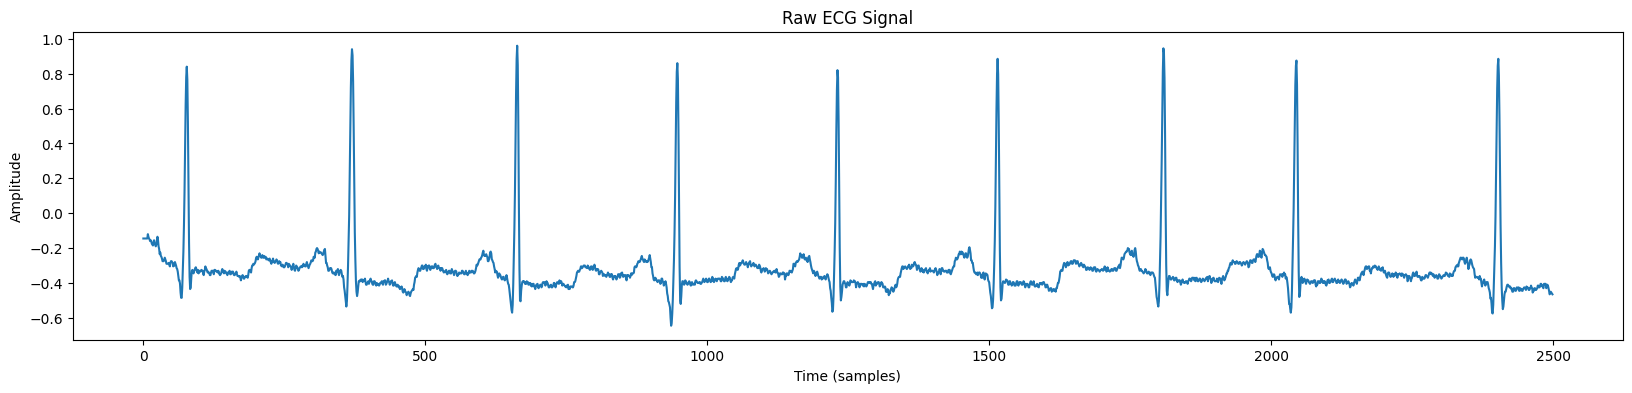

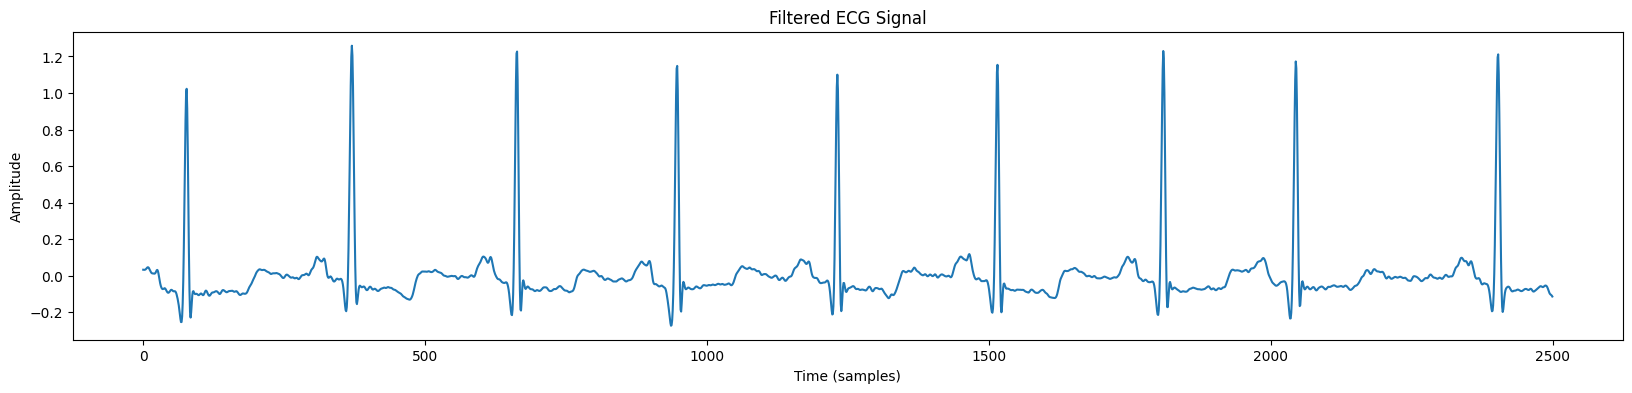

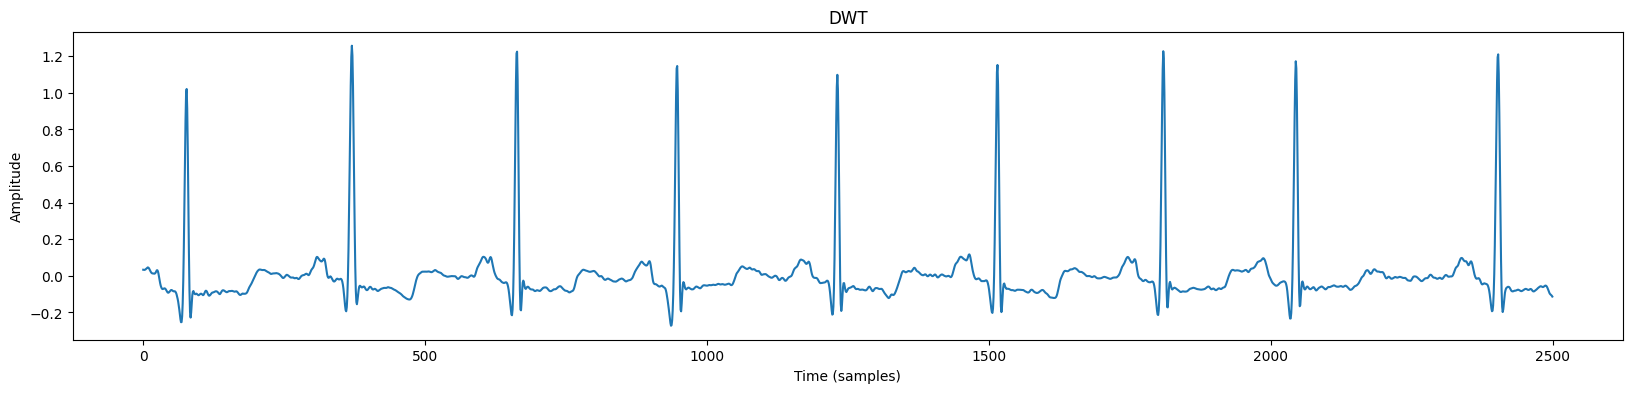

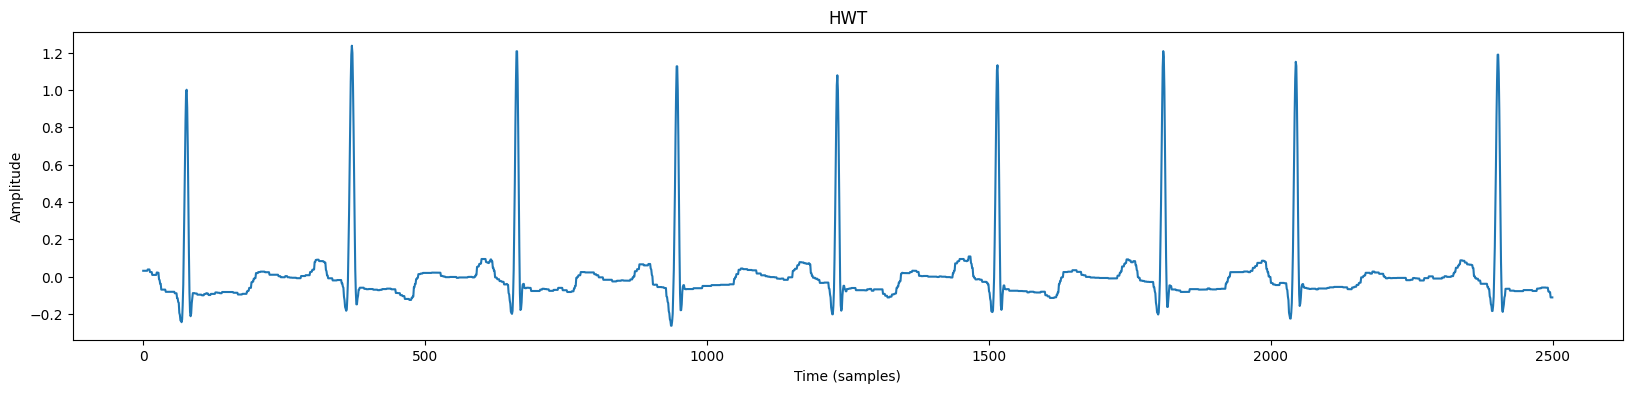

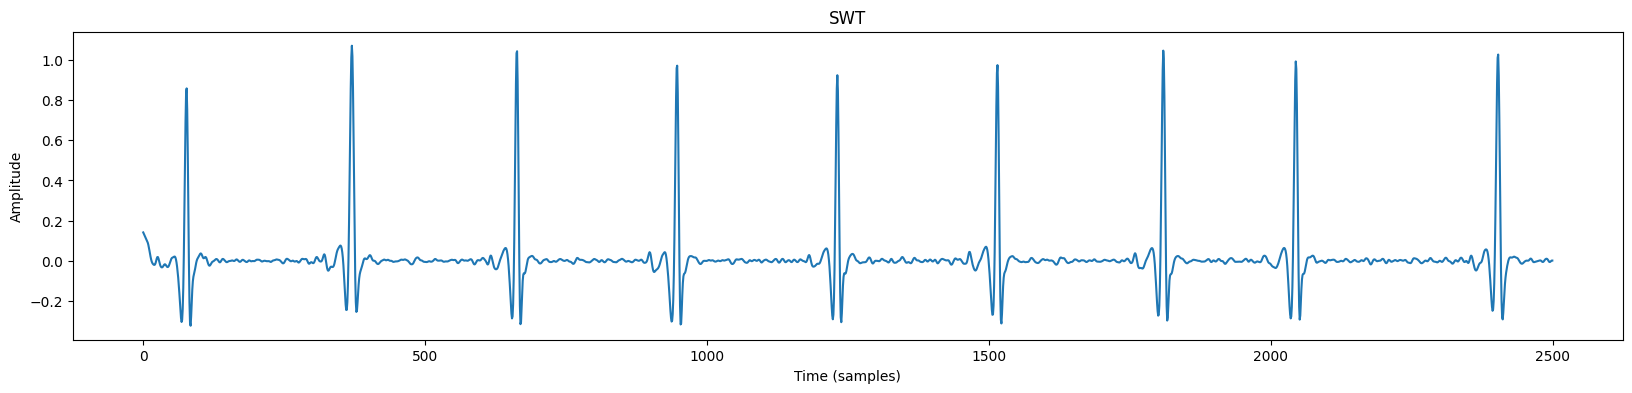

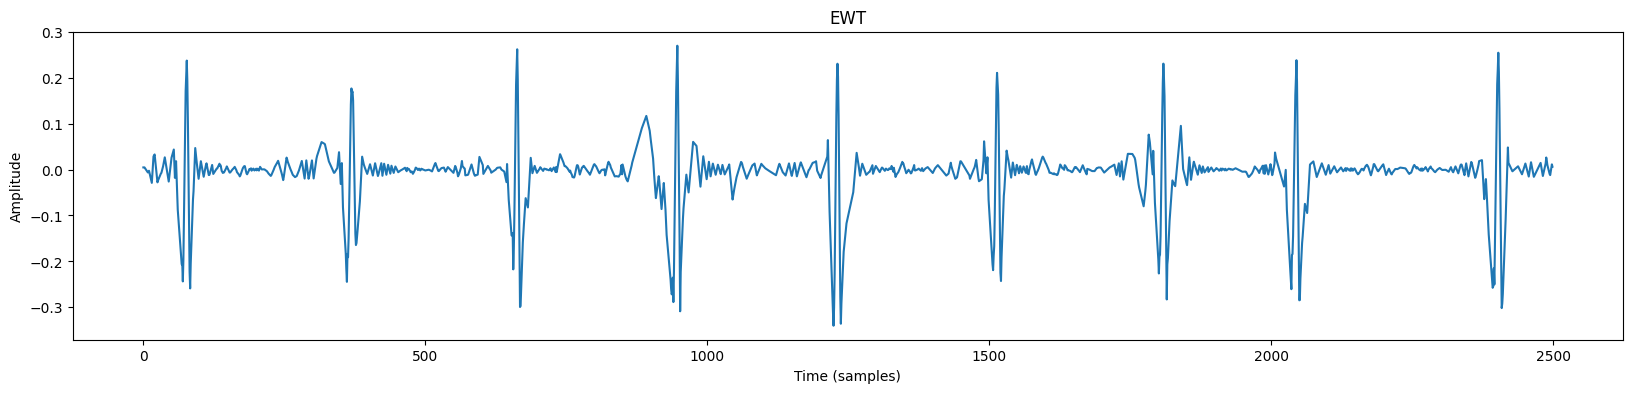

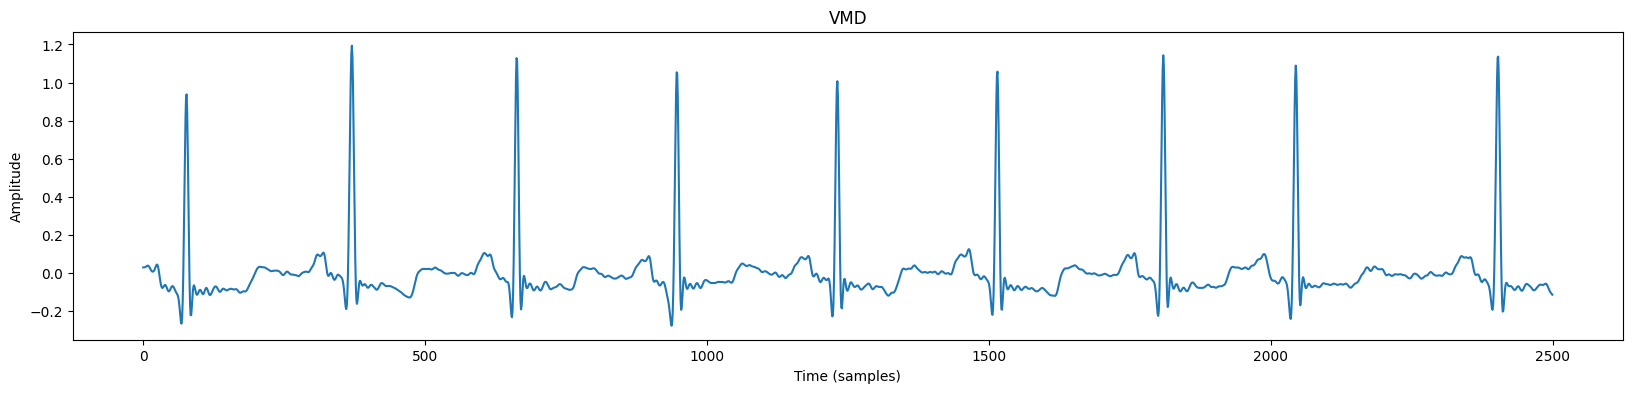

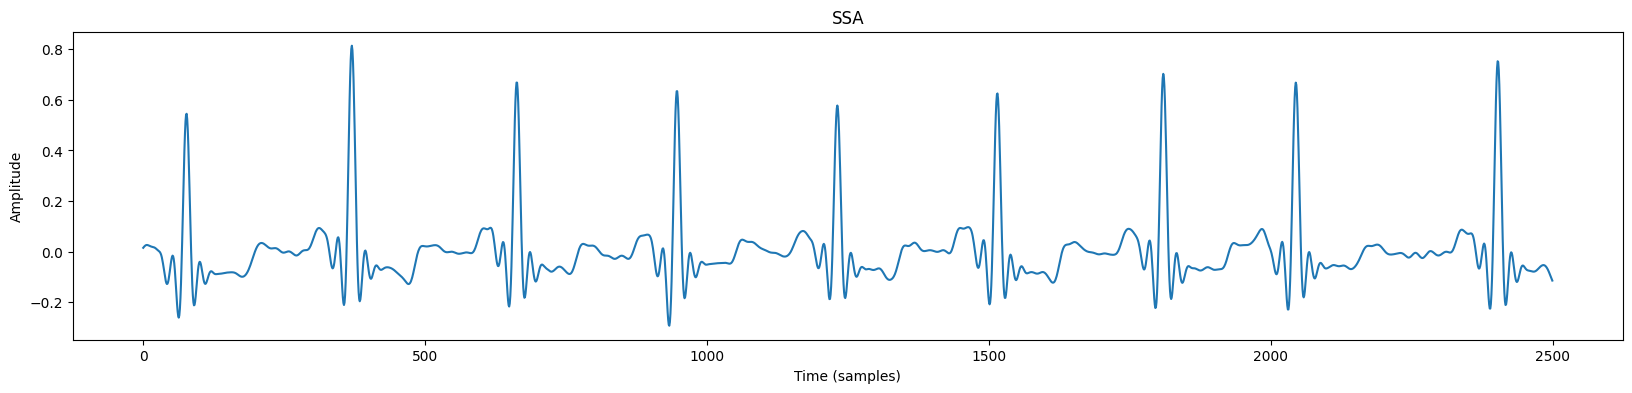

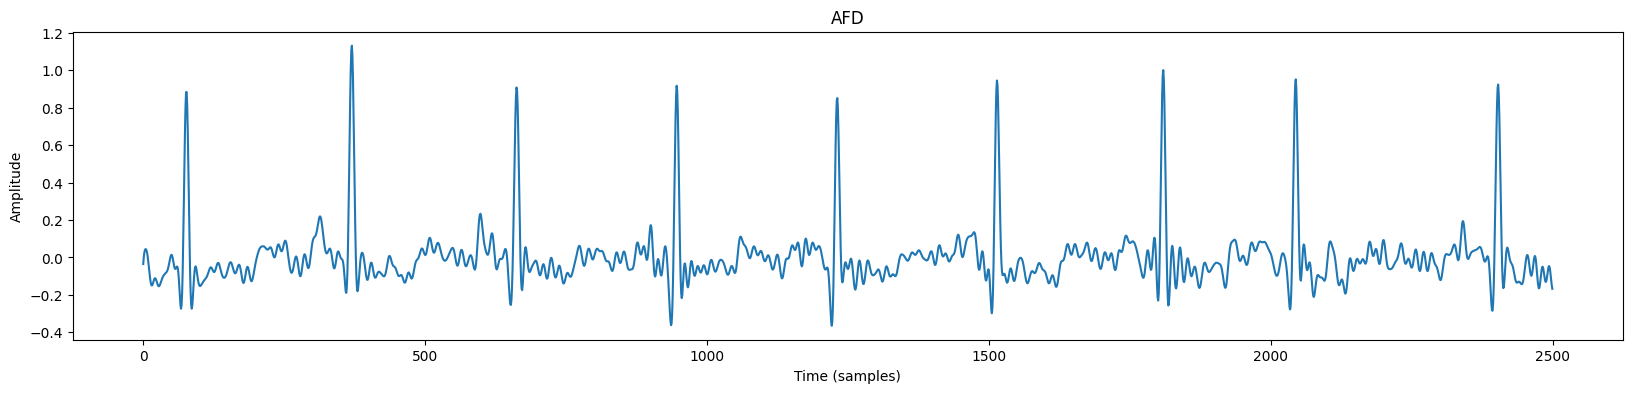

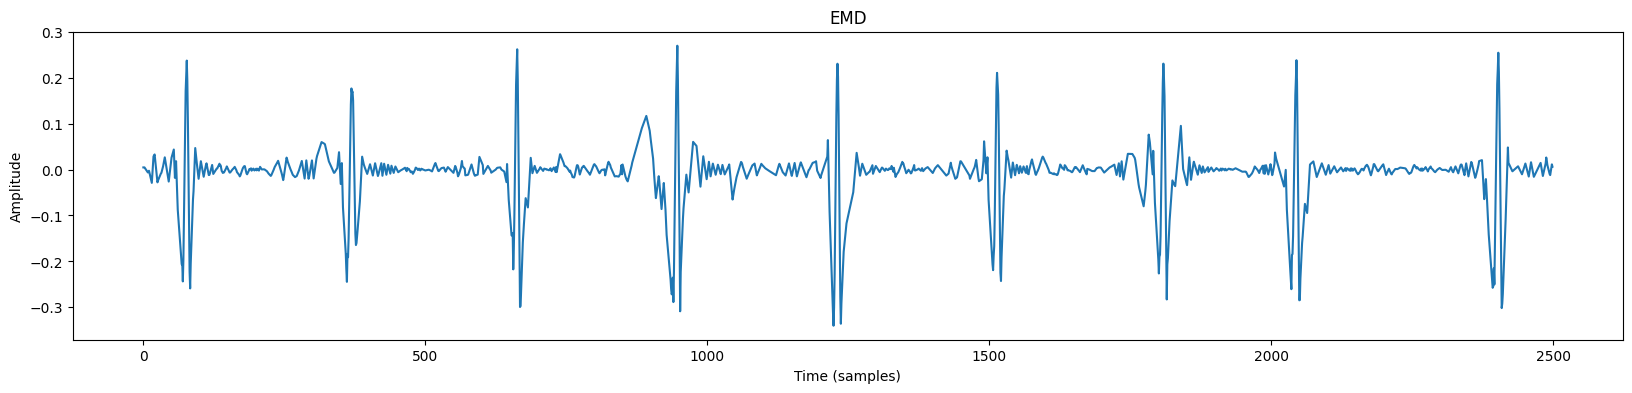

In [58]:
plt.figure(figsize=(20, 4))
plt.plot(ecg_signal[:2500])
plt.title('Raw ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(filtered_signal[:2500])
plt.title('Filtered ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

methods = {
        "DWT": dwt_denoise,
        "HWT": hwt_denoise,
        "SWT": swt_denoise,
        "EWT": emd_denoise,
        "VMD": vmd_denoise,
        "SSA": ssa_denoise,
        "AFD": afd_denoise,
        "EMD": emd_denoise
    }

results = {}
    
for name, method in methods.items():
    start_time = time.time()
    denoised_signal = method(filtered_signal)
    elapsed_time = time.time() - start_time

    plt.figure(figsize=(20, 4))
    plt.plot(denoised_signal[:2500])
    plt.title(name)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

    snr = snratio(ecg_signal, denoised_signal)
    prd = np.linalg.norm(ecg_signal - denoised_signal) / np.linalg.norm(ecg_signal) * 100
    mse = mserror(ecg_signal, denoised_signal)
    energy = energy_retention(ecg_signal, denoised_signal)
        
    results[name] = {
        "Execution Time (ms)": elapsed_time * 1000,
        "SNR": snr,
        "PRD (%)": prd,
        "MSE": mse,
        "Energy": energy
    }

In [59]:
data = pd.DataFrame(results)
data

,DWT,HWT,SWT,EWT,VMD,SSA,AFD,EMD
Execution Time (ms),0.993967,1.000643,4.002810,114.532471,1161.181450,38.011551,0.000000,108.224869
SNR,0.766205,0.754528,0.517515,0.433753,0.755506,0.519071,0.629895,0.433753
PRD (%),91.556623,91.679791,94.215906,95.128878,91.669469,94.199031,93.004775,95.128878
MSE,0.117622,0.117939,0.124554,0.126980,0.117912,0.124510,0.121373,0.126980
Energy,24.287267,23.664579,15.518102,2.778804,22.728248,16.855311,21.910979,2.778804
